# EOF Analysis of NEMO surface tracers

***

In [96]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import yaml
from matplotlib.patches import Rectangle
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm.notebook import tqdm
from salishsea_tools import viz_tools, places
from glob import glob

%matplotlib inline

In [123]:
plt.rcParams['font.size'] = 12

***

## Load data

Daterange and boilerplate netCDF objects

In [99]:
# Daterange
daterange = [datetime(2010, 1, 15), datetime(2019, 12, 15)]

# Results path
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/local/'

# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, _, _ = yaml.safe_load_all(f)

# Load NEMO netCDF files (concatentated using NCO)
mask_NEMO = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

# Slicing and indexing
skip = 5
loc = (0, 0, slice(*subdomains['NO3'][2:], skip), slice(*subdomains['NO3'][:2], skip))
tmask = mask_NEMO.tmask[loc].values.reshape(-1).astype(bool)
gridx, gridy = np.meshgrid(mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]])
gridx, gridy = gridx.reshape(-1)[tmask], gridy.reshape(-1)[tmask]

Load, reshape and concatenate results

In [101]:
# Load wind
masklims = [
    [(31, 45), (50, 30), (69, 8)],
    [(35, 48), (53, 31), (71, 12)],
    [(38, 48), (57, 30)],
]
imasklim = [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
wind = np.empty(0)
for file, ilim in zip(tqdm(sorted(glob(path + 'HRDPS*'))), imasklim):
    with xr.open_dataset(file) as ds:
        
        # Meshmask
        mask = ds.meshmask.values
        mask[:20, :20] = 0
        for lim in masklims[ilim]:
            mask[lim[0]:, lim[1]:] = 0
        mask = mask.reshape(-1).astype('bool')

        # Alongaxis wind
        u, v = [ds[var].values.reshape(-1, len(mask))[:, mask] for var in ['u_wind', 'v_wind']]
        jtau = np.sin(np.arctan2(v, u) - np.pi * (22 / 180))

        # Process and concatenate
        wind = np.concatenate((wind, (jtau * np.sqrt(u**2 + v**2)).mean(axis=1)))

In [7]:
# Load nitrate
nitrate = np.empty((0, len(gridx)))
for file in tqdm(sorted(glob(path + 'SalishSea*'))):
    with xr.open_dataset(file) as ds:
        nitrate = np.concatenate((nitrate, ds.nitrate.values[:, ::skip, ::skip].reshape(-1, len(tmask))[:, tmask]))
        
# Define date array
date = np.array([datetime(2010, 1, 1) + timedelta(hours=hour) for hour in range(len(nitrate))])

***

## Filtering
Attenuation spectra of FIR moving average filter windows

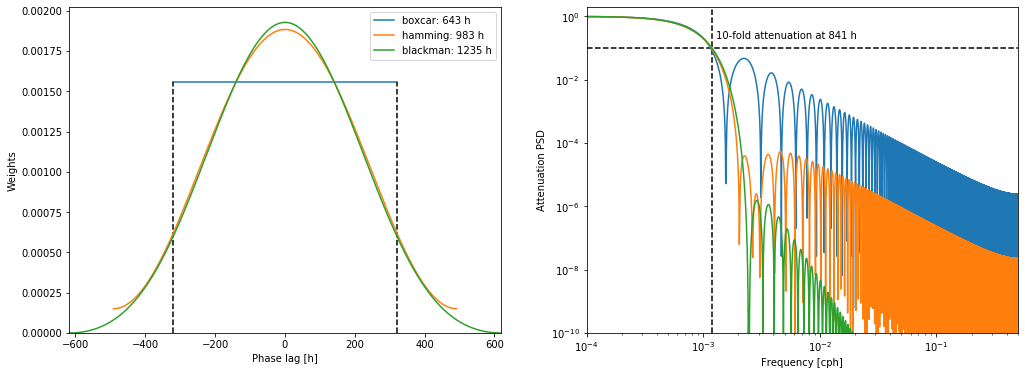

In [10]:
# Define parameters
n = nitrate.shape[0]
cutoff = 841
freq = np.linspace(-1/2, 1/2, n)
W = (cutoff / 2 * np.array([0.765, 1.168, 1.468])).astype('int') * 2 + 1
order = 10**(np.floor(np.log10(1 / cutoff)) - 1)

# Make plots
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
lims = [(-max(W)/2, max(W)/2, 0, 2.5/max(W)), (order, 1/2, 1e-10, 2)]
labels = [(f'Phase lag [h]', 'Weights'), ('Frequency [cph]', 'Attenuation PSD')]
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].plot([1/cutoff, 1/cutoff], lims[1][2:], 'k--')
axs[1].plot(lims[1][:2], [0.1, 0.1], 'k--')
axs[1].text(1/cutoff + order, 0.2, f'10-fold attenuation at {cutoff} h')
for ax, lim, label in zip(axs, lims, labels):
    ax.set_xlim(lim[:2])
    ax.set_ylim(lim[2:])
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

# Plot filters
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], W):
    w2 = (w - 1) / 2
    window = signal.get_window(window_type, w)
    window = window / sum(window)
    PSD = abs(fftshift(fft(window, n)))**2
    axs[0].plot(np.linspace(-w2, w2, w), window, label=f'{window_type}: {np.round(w):.0f} h')
    axs[1].plot(freq, PSD)
    if window_type is 'boxcar':
        [axs[0].plot([fac*w2, fac*w2], [0, window[0]], 'k--') for fac in [-1, 1]]

axs[0].legend()
plt.show()

Apply selected filter windows to surface nitrate.

Since we are subtracting the lowpass filter data, we want to preserve as much high frequency signal as possible (i.e. small sidelobes are more important than steep cutoff). We thus choose the Blackman filter.

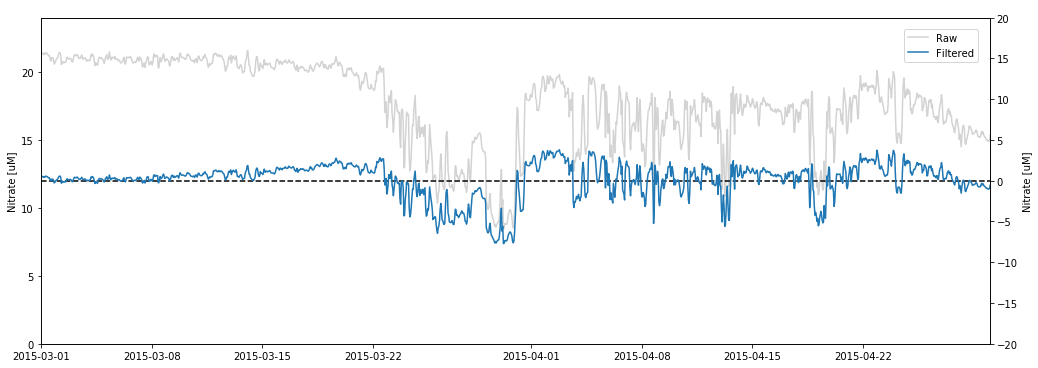

In [32]:
# Make figure
xlim = [datetime(2015, 3, 1), datetime(2015, 4, 30)]
fig, ax = plt.subplots(figsize=(17, 6))
ax.plot(date, nitrate[:, 0], '-', color='lightgray', label='Raw')
ax.set_xlim(xlim)
ax.set_ylim([0, 24])
ax.set_ylabel('Nitrate [uM]')
ax2 = ax.twinx()
ax2.plot(xlim, [0, 0], 'k--')
ax2.set_ylim([-20, 20])
ax2.set_ylabel('Nitrate [uM]')

# Calculate bandpass as difference between windows
window_type, w = 'blackman', 1235
nitrate_highpass = {}
window = signal.get_window(window_type, w)
window = window / sum(window)
nitrate_highpass[window_type] = np.empty(nitrate.shape)
for i, loc in zip(range(nitrate.shape[1]), nitrate.T):
    nitrate_highpass[window_type][:, i] = loc - signal.convolve(loc, window, mode='same')
ax2.plot(date, nitrate_highpass[window_type][:, 0], label='Filtered')
fig.legend(loc=(0.87, 0.83))
plt.show()

***

## Calculate EOF

In [27]:
def varimax(A, maxiter=30, tol=1e-5):
    """From Horst 1965
    with modifications from Ben FrantzDale on Wikipedia talkpage
    https://en.wikipedia.org/wiki/Talk:Varimax_rotation
    """
    
    n, p = A.shape
    H = np.eye(p)
    d = 0
    convergence = []
    for i in tqdm(range(maxiter)):
        d_old = d
        B = A.dot(H)  # -------------------------------------------------------- 18.4.5
        beta = B * B * B - B.dot(np.diag(np.diag(B.T.dot(B)))) / n  # ---------- 18.4.1
        C = A.T.dot(beta)  # --------------------------------------------------- 18.4.2
        u, s, vh = np.linalg.svd(C)  # -- 18.4.3 (modified by Ben FrantzDale (Wikipedia) to use SVD)
        H = u.dot(vh)  # ---------------- 18.4.4 (modified by Ben FrantzDale (Wikipedia))
        d = sum(s)
        convergence.append(d)
        if d_old != 0 and d/d_old < 1 + tol: break
    return H, convergence

In [105]:
# Extract winter
z = np.empty((0, len(gridx)))
w = np.empty(0)
t = np.empty(0)
for year in range(2010, 2020):
    index = [abs(date - datetime(year, month, 1)).argmin() for month in [3, 10]]
    t = np.concatenate((t, date[slice(*index)]))
    z = np.concatenate((z, nitrate_highpass['blackman'][slice(*index), :]))
    w = np.concatenate((w, wind[slice(*index)]))
z = z - z.mean(axis=0)[np.newaxis, :]

In [41]:
# EOF analysis
EOF = {}
A_prime, sqrtL, E_T = np.linalg.svd(z, full_matrices=False)
EOF['A'] = A_prime.dot(np.diag(sqrtL))
A2 = EOF['A'] * EOF['A']
EOF['var'] = A2.sum(axis=0) / A2.sum()
EOF['E'] = E_T.T

In [42]:
# Get varimax rotation matrix
R, convergence = varimax(EOF['A'])

# Rotate matrices
EOF['B'] = EOF['A'].dot(R)
B2 = EOF['B'] * EOF['B']
EOF['var_rot'] = B2.sum(axis=0) / B2.sum()
EOF['U'] = EOF['E'].dot(R)

***

## Summary Paper Figs

In [12]:
plt.rcParams['font.size'] = 11

EOF summary

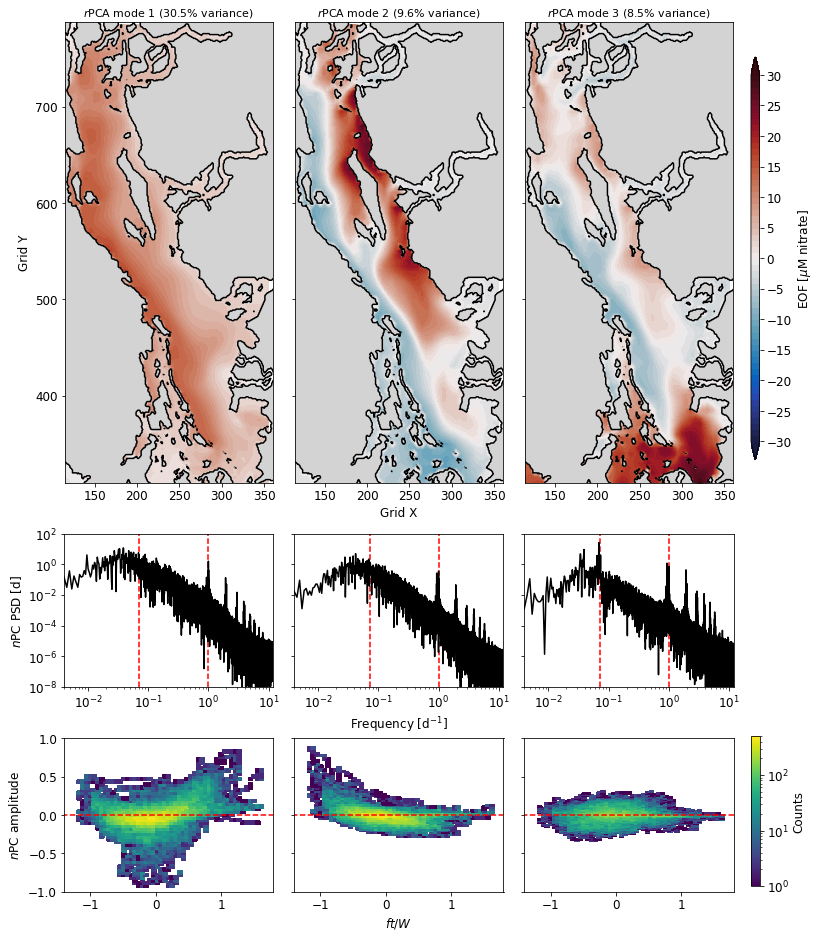

In [148]:
# Make figure and plotting params
fig, axs = plt.subplots(3, 3, figsize=(12, 16), gridspec_kw={'wspace': 0.1, 'hspace': 0.2, 'height_ratios': [3, 1, 1]})

# Plot EOFs
plotx, ploty = mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]]
for ax, mode in zip(axs[0, :], range(3)):
    gridded = np.zeros(mask_NEMO.nav_lon.shape)
    for y, x, val in zip(gridy, gridx, EOF['U'][:, mode]): gridded[y, x] = val
    gridded = gridded[loc[2:]]
    c = ax.contourf(plotx, ploty, -1*gridded*350, levels=np.arange(-30, 31, 1), cmap=cm.balance, extend='both')
    for C in c.collections: C.set_edgecolor('face')
    ax.contourf(mask_NEMO.x, mask_NEMO.y, mask_NEMO.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(mask_NEMO.x, mask_NEMO.y, mask_NEMO.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    viz_tools.set_aspect(ax)
    ax.set_xlim(subdomains['NO3'][:2])
    ax.set_ylim(subdomains['NO3'][2:])
    #ax.text(0.9, 0.97, f'({chr(97+mode)})', transform=ax.transAxes)
    if mode == 0:
        ax.set_ylabel('Grid Y')
    else: ax.yaxis.set_ticklabels('')
    if mode == 1: ax.set_xlabel('Grid X')
    ax.set_title(f"$r$PCA mode {mode+1} ({EOF['var_rot'][mode]*100:.01f}% variance)", fontsize=11)

# Plot PCs
xlim, ylim = [4e-3, 12], [1e-8, 1e2]
freq = np.linspace(-12, 12, EOF['B'].shape[0])
for ax, mode in zip(axs[1, :], range(3)):
    for peak in [1, 14]: ax.plot([1/peak, 1/peak], ylim, 'r--')
    PSD = abs(fftshift(fft(EOF['B'][:, mode]/350)))**2 / 86400
    ax.plot(freq, PSD, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #ax.text(0.9, 0.91, f'({chr(100+mode)})', transform=ax.transAxes)
    if mode == 0:
        ax.set_ylabel('$n$PC PSD [d]')
    else: ax.yaxis.set_ticklabels('')
    if mode == 1: ax.set_xlabel('Frequency [d$^{-1}$]')

# Plot wind correlation
indices = [0] + list(np.where(np.diff(t) > timedelta(hours=1))[0] + 1) + [len(t)]
w_int = np.empty(len(w))
for n in range(len(indices) - 1):
    for i in range(*indices[n:n+2]):
        w_int[i] = sum(w[i-min(i, 48):i]) * 3600
for ax, mode in zip(axs[2, :], range(3)):
    ax.plot([-1.8, 1.8], [0, 0], 'r--')
    _, _, _, h = ax.hist2d(w_int[48:]*1e-6, -1*EOF['B'][48:, mode]/350, bins=50, norm=mcolors.LogNorm(vmin=1, vmax=5e2))
    h.set_edgecolor('face')
    ax.set_xlim([-1.4, 1.8])
    ax.set_ylim([-1, 1])
    #ax.text(0.9, 0.91, f'({chr(103+mode)})', transform=ax.transAxes)
    if mode == 0:
        ax.set_ylabel('$n$PC amplitude')
    else: ax.yaxis.set_ticklabels('')
    if mode == 1: ax.set_xlabel('$ft/W$')
        
cax = [fig.add_axes([0.92, y[0], 0.01, y[1]]) for y in [(0.5, 0.35), (0.13, 0.13)]]
cbar = fig.colorbar(c, cax=cax[0], ticks=np.arange(-30, 31, 5), label='EOF [$\\mu$M nitrate]')
cbar.solids.set_edgecolor('face')
plt.draw()
fig.colorbar(h, cax=cax[1], label='Counts')
    
fig.savefig('/home/bmoorema/Desktop/Newfigs/EOF.pdf', bbox_inches='tight')

PC timeseries summary

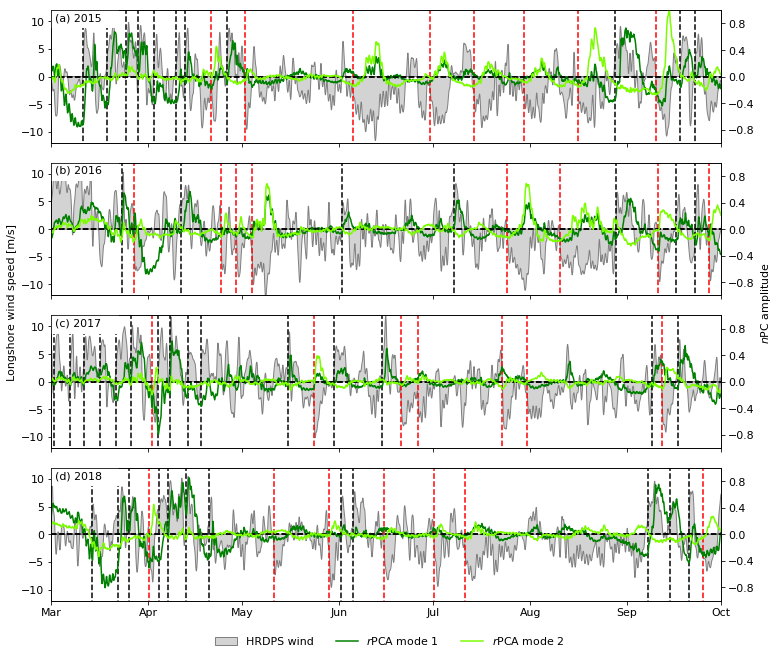

In [22]:
window = signal.get_window('blackman', 25)
window = window / sum(window)
l = [0, 0, 0]

fig, axs = plt.subplots(4, 1, figsize=(12, 10), gridspec_kw={'hspace': 0.15})
for ax, year in zip(axs, range(2015, 2019)):
    xlim = [datetime(year, month, 1) for month in [3, 10]]
    l[0] = ax.fill_between(tw, signal.convolve(wind, window, mode='same'), facecolor='lightgray', edgecolor='gray')
    ax.set_xlim(xlim)
    ax.set_ylim([-12, 12])
    ax2 = ax.twinx()
    ax2.set_ylim([-1, 1])
    ax2.yaxis.set_ticks(np.arange(-0.8, 1, 0.4))
    if year == 2017:
        ax.set_ylabel('Longshore wind speed [m/s]', y=1.1)
        ax2.set_ylabel('$n$PC amplitude', y=1.1)
    for mode, fac, color in zip(range(2), [-1, 1], ['g', 'lawngreen']):
        ax2.plot(xlim, [0, 0], 'k--')
        l[mode+1], = ax2.plot(t, fac*EOF['B'][:, mode]/300, '-', color=color)
    ax.xaxis.set_major_locator(getattr(mdates, 'MonthLocator')())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    if year < 2018: ax.xaxis.set_ticklabels('')
    ax.add_patch(Rectangle((0, 0.87), 0.1, 0.13, facecolor='w', edgecolor='w', transform=ax.transAxes, zorder=10))
    ax.text(0.005, 0.92, f'({chr(year - 1918)}) {year}', transform=ax.transAxes, zorder=10)
    
    for dates, color in zip([dates_south, dates_north], ['k', 'r']):
        for date in dates:
            date = parse(date)
            if date.year == year:
                ax.plot([date, date], [-14.5, 14.5], '--', color=color)
fig.legend(handles=l, labels=['HRDPS wind', '$r$PCA mode 1', '$r$PCA mode 2'], ncol=3, loc=[0.27, 0], frameon=False)
plt.subplots_adjust(bottom=0.06)
fig.savefig('/home/bmoorema/Desktop/PCs.pdf', bbox_inches='tight')